In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import sys

src_dir = os.path.join(os.getcwd(), os.pardir, 'src')
sys.path.append(src_dir)

In [3]:
import pickle

import numpy as np
import pandas as pd

# Set the seed for Keras
np.random.seed(4)

from model.model import get_model, split_train_test

from model.predictions import fit_model, predict, assemble_submission, convert_predictions, AMAPE

from utils.visualisations import PenguinVisualisation

Using Theano backend.


In [4]:
# Use the same features without noise added computed for Submission 2
fname = '../data/interim/Submission_03/features.p'
df_train, df_test, df_features, _, features, scaler = pickle.load(open(fname, 'rb'))
df_train, df_test = split_train_test(df_features)

In [5]:
print(df_train.shape, df_test.shape)
df_train.head()

(15552, 38) (3240, 38)


y_true inferred_y_true inferred_t   t0   t1   t2  \
site_id species        year                                                     
ACUN    adelie penguin 1984     0.0            True       True  0.0  0.0  0.0   
                       1985     0.0            True       True  0.0  0.0  0.0   
                       1986     0.0            True       True  0.0  0.0  0.0   
                       1987     0.0            True       True  0.0  0.0  0.0   
                       1988     0.0            True       True  0.0  0.0  0.0   

                              t3  countError  adelie penguin  \
site_id species        year                                    
ACUN    adelie penguin 1984  0.0    0.707107             1.0   
                       1985  0.0    0.707107             1.0   
                       1986  0.0    0.707107             1.0   
                       1987  0.0    0.707107             1.0   
                       1988  0.0    0.707107             1.0   

                             chinstrap penguin      ...        temp_month_2  \
site_id species        year                         ...                       
ACUN    adelie penguin 1984                0.0      ...               -0.21   
                       1985                0.0      ...                1.59   
                       1986                0.0      ...                0.55   
                       1987                0.0      ...                0.25   
                       1988                0.0      ...                0.24   

                             temp_month_3  temp_month_4  temp_month_5  \
site_id species        year                                             
ACUN    adelie penguin 1984          0.38         -0.27         -0.28   
                       1985          0.53         -0.32          1.42   
                       1986          0.43          1.13          1.22   
                       1987          0.37          0.68         -0.48   
                       1988          0.93          0.93          0.26   

                             temp_month_6  temp_month_7  temp_month_8  \
site_id species        year                                             
ACUN    adelie penguin 1984          2.39         -3.26         -0.48   
                       1985          0.49         -1.65          5.43   
                       1986          0.29          3.89          0.27   
                       1987          0.69         -2.00         -5.22   
                       1988          1.74         -1.30          0.12   

                             temp_month_9  temp_month_10  temp_month_11  
site_id species        year                                              
ACUN    adelie penguin 1984          3.94           4.12          -0.49  
                       1985          4.25           4.07           0.76  
                       1986          0.44          -0.73          -0.69  
                       1987          1.80          -2.63          -1.79  
                       1988         -4.30          -0.22          -1.70  

[5 rows x 38 columns]

In [6]:
df_train.columns

Index(['y_true', 'inferred_y_true', 'inferred_t', 't0', 't1', 't2', 't3',
       'countError', 'adelie penguin', 'chinstrap penguin', 'gentoo penguin',
       'proximityNestCountChange', 'siteCount', 'sea_ice_month_0',
       'sea_ice_month_1', 'sea_ice_month_2', 'sea_ice_month_3',
       'sea_ice_month_4', 'sea_ice_month_5', 'sea_ice_month_6',
       'sea_ice_month_7', 'sea_ice_month_8', 'sea_ice_month_9',
       'sea_ice_month_10', 'sea_ice_month_11', 'krill', 'temp_month_0',
       'temp_month_1', 'temp_month_2', 'temp_month_3', 'temp_month_4',
       'temp_month_5', 'temp_month_6', 'temp_month_7', 'temp_month_8',
       'temp_month_9', 'temp_month_10', 'temp_month_11'],
      dtype='object')

In [7]:
# Get the model
ts_steps = 4
aux_input_size = 6
model = get_model(ts_steps, aux_input_size=aux_input_size)

In [8]:
# Run the fitting
batch_size = 256
model, history = fit_model(df_train, model, df_test, validation_split=0., batch_size=batch_size, epochs=400, verbose=0)

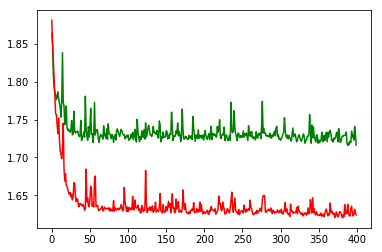

In [9]:
plt.plot(history.history['val_loss'], color='green')
plt.plot(history.history['loss'], color='red');

Epoch with lowest validation loss is epoch 388 with a loss of 1.72
Manually chosen epoch is epoch 388 with a loss of 1.72


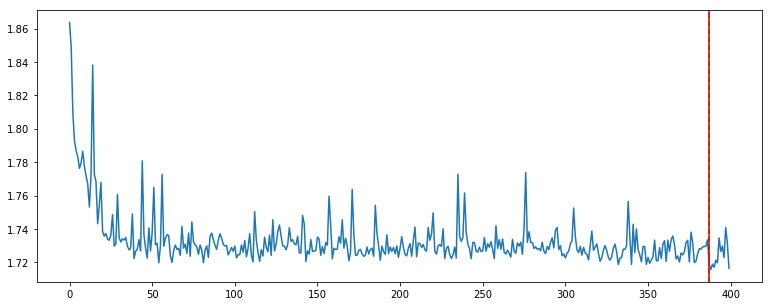

In [10]:
# Show the history of the validation loss and select the "best" number of epochs to run
val_loss = history.history['val_loss']
best_epoch_auto = np.argmin(val_loss)
best_epoch = best_epoch_auto

print("Epoch with lowest validation loss is epoch %i with a loss of %.2f" %(best_epoch_auto, val_loss[best_epoch_auto]))
print("Manually chosen epoch is epoch %i with a loss of %.2f" %(best_epoch, val_loss[best_epoch]))


fig = plt.figure(figsize=(13,5))
ax = fig.add_subplot(111)
ax.plot(val_loss)
ax.axvline(best_epoch-1, color='green', linestyle='dashed');
ax.axvline(best_epoch_auto-1, color='red');

In [11]:
# Get the model
np.random.seed(4)
ts_steps = 4
aux_input_size = 6
model = get_model(ts_steps, aux_input_size=aux_input_size)
model, history = fit_model(df_train, model, df_test, validation_split=0., batch_size=batch_size, epochs=best_epoch, verbose=0)

Epoch with lowest validation loss is epoch 388 with a loss of 1.72


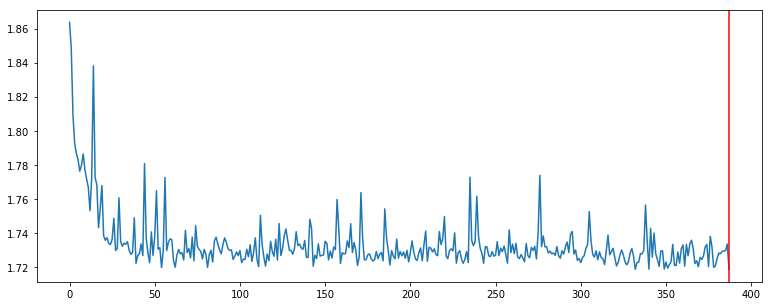

In [12]:
val_loss_re = history.history['val_loss']
best_epoch_re = np.argmin(val_loss_re) + 1

print("Epoch with lowest validation loss is epoch %i with a loss of %.2f" %(best_epoch_re, val_loss_re[best_epoch_re-1]))

fig = plt.figure(figsize=(13,5))
ax = fig.add_subplot(111)
ax.plot(val_loss_re)
ax.axvline(best_epoch_re-1, color='red');

In [13]:
# Predict the steps ahead
idx = df_features.reset_index()['year'].apply(int) < 2011
df_features_pred = df_features.loc[np.array(idx),:]

df_predictions = predict(df_features_pred, 4, model, features)
df_predictions.head()

adelie penguin  chinstrap penguin  countError  \
site_id species        year                                                  
ACUN    adelie penguin 1984             1.0                0.0    0.707107   
                       1985             1.0                0.0    0.707107   
                       1986             1.0                0.0    0.707107   
                       1987             1.0                0.0    0.707107   
                       1988             1.0                0.0    0.707107   

                             gentoo penguin inferred_t  inferred_y_true  \
site_id species        year                                               
ACUN    adelie penguin 1984             0.0       True              1.0   
                       1985             0.0       True              1.0   
                       1986             0.0       True              1.0   
                       1987             0.0       True              1.0   
                       1988             0.0       True              1.0   

                                krill  proximityNestCountChange  \
site_id species        year                                       
ACUN    adelie penguin 1984  1.051298                 -0.018746   
                       1985  5.788702                 -0.019476   
                       1986  0.000000                 -0.020265   
                       1987  0.000000                 -0.021121   
                       1988  4.264471                 -0.022053   

                             sea_ice_month_0  sea_ice_month_1   ...    \
site_id species        year                                     ...     
ACUN    adelie penguin 1984         0.028333         0.000000   ...     
                       1985         0.000000         0.000000   ...     
                       1986         0.060278         0.006667   ...     
                       1987         0.043889         0.000278   ...     
                       1988         0.083611         0.055741   ...     

                             temp_month_2  temp_month_3  temp_month_4  \
site_id species        year                                             
ACUN    adelie penguin 1984         -0.21          0.38         -0.27   
                       1985          1.59          0.53         -0.32   
                       1986          0.55          0.43          1.13   
                       1987          0.25          0.37          0.68   
                       1988          0.24          0.93          0.93   

                             temp_month_5  temp_month_6  temp_month_7  \
site_id species        year                                             
ACUN    adelie penguin 1984         -0.28          2.39         -3.26   
                       1985          1.42          0.49         -1.65   
                       1986          1.22          0.29          3.89   
                       1987         -0.48          0.69         -2.00   
                       1988          0.26          1.74         -1.30   

                             temp_month_8  temp_month_9    y_pred  y_true  
site_id species        year                                                
ACUN    adelie penguin 1984         -0.48          3.94  0.000041     0.0  
                       1985          5.43          4.25  0.000041     0.0  
                       1986          0.27          0.44  0.000041     0.0  
                       1987         -5.22          1.80  0.000041     0.0  
                       1988          0.12         -4.30  0.000041     0.0  

[5 rows x 39 columns]

Observation: 0.88 percent of the values fall into the shown range.
Prediction: 0.95 percent of the values fall into the shown range.


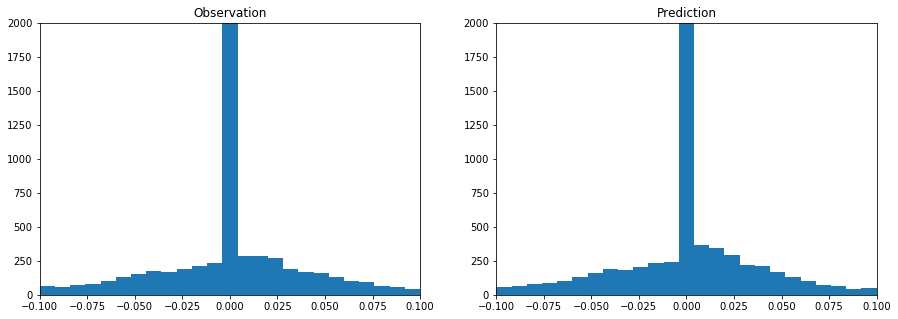

In [14]:
# Check if the predictions have a similar distribution

fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

low, high = -.1, .1

hist_observation = df_predictions.reset_index()
hist_observation = hist_observation[hist_observation['year'].apply(int) <= 2013]
hist_observation = hist_observation['y_true'][(hist_observation['y_true'] >= low) & (hist_observation['y_true'] <= high)]

hist_prediction = df_predictions['y_pred'][(df_predictions['y_pred'] >= low) & (df_predictions['y_pred'] <= high)]

print("Observation: %.2f percent of the values fall into the shown range." %(hist_observation.shape[0]/df_predictions.shape[0]))
print("Prediction: %.2f percent of the values fall into the shown range." %(hist_prediction.shape[0]/df_predictions.shape[0]))


ax1.hist(hist_observation, bins=25)
ax2.hist(hist_prediction, bins=25)

ax1.set_xlim((-.1,.1))
ax2.set_xlim((-.1,.1))

ax1.set_ylim((0,2000))
ax2.set_ylim((0,2000))

ax1.set_title('Observation')
ax2.set_title('Prediction');

In [15]:
# Rescale the predictions
df_predictions = convert_predictions(df_predictions, scaler)
df_predictions = df_predictions.round()
df_predictions.head()

year                           1984      1985      1986      1987      1988  \
site_id species                                                               
ACUN    adelie penguin       2008.0    2008.0    2008.0    2008.0    2008.0   
        chinstrap penguin    4000.0    4000.0    4000.0    4000.0    4000.0   
ADAM    adelie penguin         76.0      76.0      76.0      76.0      76.0   
ADAR    adelie penguin     264150.0  272624.0  281139.0  277169.0  272227.0   
AILS    chinstrap penguin    6000.0    6000.0    6000.0    6000.0    6000.0   

year                           1989      1990      1991      1992      1993  \
site_id species                                                               
ACUN    adelie penguin       2008.0    2008.0    2008.0    2008.0    2008.0   
        chinstrap penguin    4000.0    4000.0    4000.0    4000.0    4000.0   
ADAM    adelie penguin         76.0      76.0      76.0      76.0      76.0   
ADAR    adelie penguin     224571.0  174798.0  210072.0  279255.0  302966.0   
AILS    chinstrap penguin    6000.0    6000.0    6000.0    6000.0    6000.0   

year                         ...         2006      2007      2008      2009  \
site_id species              ...                                              
ACUN    adelie penguin       ...       2244.0    2445.0    2646.0    2846.0   
        chinstrap penguin    ...       4000.0    4000.0    4000.0    4000.0   
ADAM    adelie penguin       ...         76.0      76.0      76.0      76.0   
ADAR    adelie penguin       ...     338433.0  338387.0  338342.0  338296.0   
AILS    chinstrap penguin    ...       6000.0    6000.0    6000.0    6000.0   

year                           2010      2011      2012      2013      2014  \
site_id species                                                               
ACUN    adelie penguin       3046.0    3078.0    3079.0    3079.0    3079.0   
        chinstrap penguin    4000.0    4000.0    4000.0    4000.0    4001.0   
ADAM    adelie penguin         76.0      76.0      76.0      76.0      76.0   
ADAR    adelie penguin     338251.0  363289.0  391059.0  419079.0  447289.0   
AILS    chinstrap penguin    6000.0    6000.0    6000.0    6001.0    6001.0   

year                           2015  
site_id species                      
ACUN    adelie penguin       3079.0  
        chinstrap penguin    4001.0  
ADAM    adelie penguin         76.0  
ADAR    adelie penguin     463945.0  
AILS    chinstrap penguin    6002.0  

[5 rows x 32 columns]

AMAPE 2011: 0.13
AMAPE 2012: 0.23
AMAPE 2013: 0.88
Projected AMAPE score: 1.24


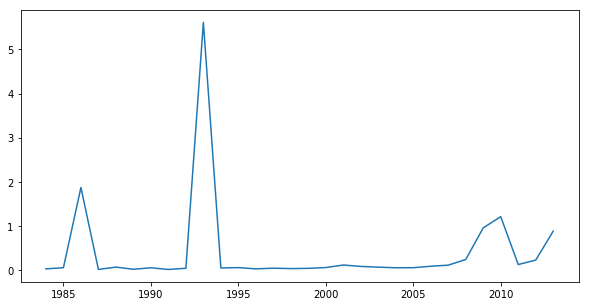

In [16]:
# Show some estimate of what the final score for the test set would be.
# First, show the score for all data (i.e. including the interpolated counts)
amape = AMAPE(interpolated=True)
amapeScore = amape.amape(df_predictions)

print("AMAPE 2011: %.2f" %amapeScore.loc['2011'])
print("AMAPE 2012: %.2f" %amapeScore.loc['2012'])
print("AMAPE 2013: %.2f" %amapeScore.loc['2013'])
print("Projected AMAPE score: %.2f" %(amapeScore.loc['2011']+amapeScore.loc['2012']+amapeScore.loc['2013']))

plt.figure(figsize=(10,5))
plt.plot(amapeScore);

AMAPE 2011: 1.05
AMAPE 2012: 1.31
AMAPE 2013: 6.91
Projected AMAPE score: 9.28


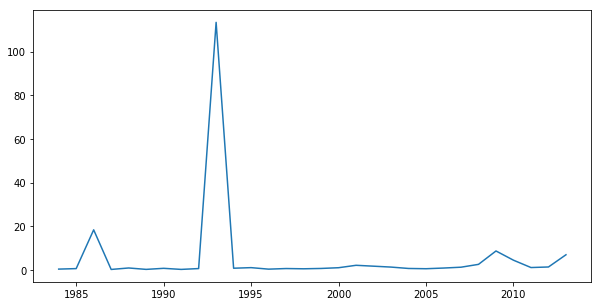

In [17]:
# Show the score only for the truly observed predictions. This will be harder to predict since the interpolated
# data is smooth and thus much easier to predict.
amape = AMAPE(interpolated=False)
amapeScore = amape.amape(df_predictions)

print("AMAPE 2011: %.2f" %amapeScore.loc['2011'])
print("AMAPE 2012: %.2f" %amapeScore.loc['2012'])
print("AMAPE 2013: %.2f" %amapeScore.loc['2013'])
print("Projected AMAPE score: %.2f" %(amapeScore.loc['2011']+amapeScore.loc['2012']+amapeScore.loc['2013']))

plt.figure(figsize=(10,5))
plt.plot(amapeScore);

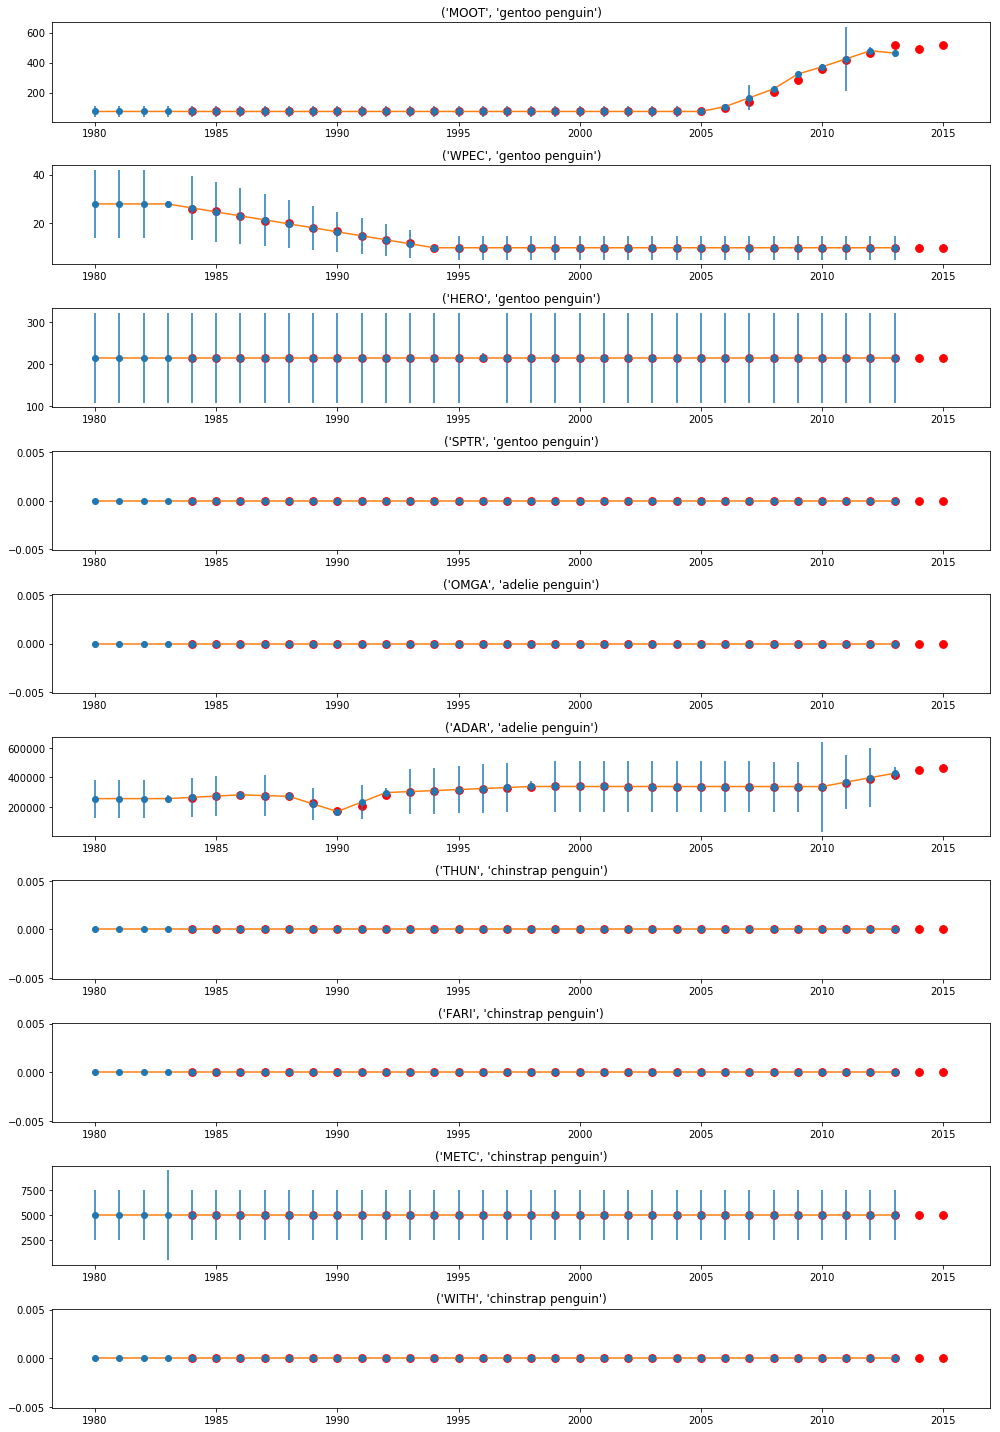

In [18]:
# Have look at some random sites and species and check if the model seems to make sense
vis = PenguinVisualisation(df_predictions)
vis.plot_random()

In [19]:
# Finally, retrain the model with the full data and make the predictions for the submission
np.random.seed(4)
model = get_model(ts_steps, aux_input_size=aux_input_size)
model, _ = fit_model(df_features, model, None, batch_size=batch_size, epochs=best_epoch, verbose=0)

# Make the predictions
df_predictions = predict(df_features, 4, model, features)
df_predictions = convert_predictions(df_predictions, scaler)
df_predictions = df_predictions.round()

# Prepare the submission
df_submission = assemble_submission(df_predictions)
df_submission.head()

2014      2015      2016      2017
site_id common_name                                              
ACUN    adelie penguin       3080.0    3081.0    3081.0    3083.0
        chinstrap penguin    4002.0    4003.0    4004.0    4007.0
ADAM    adelie penguin         76.0      76.0      76.0      76.0
ADAR    adelie penguin     448745.0  464016.0  477705.0  488942.0
AILS    chinstrap penguin    6003.0    6004.0    6006.0    6010.0

AMAPE 2011: 1.08
AMAPE 2012: 0.41
AMAPE 2013: 3.58
Projected AMAPE score: 5.06


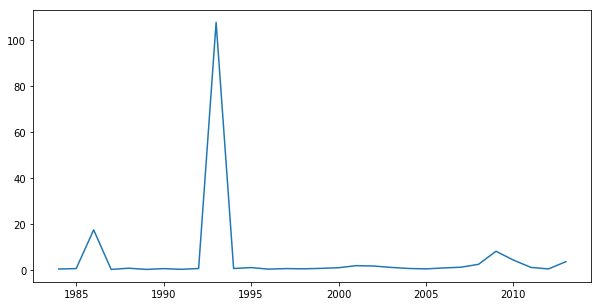

In [20]:
# Check if the score changes much compared to the run without the test data.
amape = AMAPE(interpolated=False)
amapeScore = amape.amape(df_predictions)

print("AMAPE 2011: %.2f" %amapeScore.loc['2011'])
print("AMAPE 2012: %.2f" %amapeScore.loc['2012'])
print("AMAPE 2013: %.2f" %amapeScore.loc['2013'])
print("Projected AMAPE score: %.2f" %(amapeScore.loc['2011']+amapeScore.loc['2012']+amapeScore.loc['2013']))

plt.figure(figsize=(10,5))
plt.plot(amapeScore);

In [21]:
fname_submission = '../data/submission/submission_03.1.csv'
df_submission.to_csv(fname_submission, index=True)